In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

plt.style.use('seaborn-v0_8')

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_RAW_DIR = os.path.join(PROJECT_ROOT, "data", "raw")
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)

print("Python executable:", sys.executable)
print("Raw data dir:", DATA_RAW_DIR)
print("Processed data dir:", DATA_PROCESSED_DIR)

Python executable: c:\DAT494\bayesian_regime_switching\.venv\Scripts\python.exe
Raw data dir: c:\DAT494\bayesian_regime_switching\data\raw
Processed data dir: c:\DAT494\bayesian_regime_switching\data\processed


## Specify Tickers

In [2]:
TICKER = "^GSPC"  # S&P 500 index
START_DATE = "2000-01-01"
END_DATE = "2025-11-30"

In [4]:
def download_price_data(ticker, start, end):
    """Download historical price data from Yahoo Finance."""

    df = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        group_by='column',     # <- important
        auto_adjust=False      # keep original adjusted close
    )

    if df.empty:
        raise ValueError(f"No data returned for {ticker}. Check ticker or date range.")

    # If columns are MultiIndex, flatten or extract the correct level
    if isinstance(df.columns, pd.MultiIndex):
        # Try to find 'Adj Close' in any level
        # First, flatten for debugging if needed
        print("MultiIndex columns detected, columns are:", df.columns)

        # Common case: price fields like 'Adj Close', 'Close' at one level
        # Try to extract 'Adj Close' or 'Close' across levels
        adj_candidates = []
        for col in df.columns:
            # col is a tuple in MultiIndex
            if any(str(level).strip().lower() in ("adj close", "adjclose") for level in col):
                adj_candidates.append(col)
        
        if not adj_candidates:
            # Fallback: try 'Close'
            for col in df.columns:
                if any(str(level).strip().lower() == "close" for level in col):
                    adj_candidates.append(col)

        if not adj_candidates:
            raise KeyError(
                f"Could not find an 'Adj Close' or 'Close' column in MultiIndex columns: {df.columns}"
            )

        # Take the first matching column
        adj_series = df[adj_candidates[0]].copy()
    else:
        # Normal flat columns case
        cols = [c.lower().replace(" ", "") for c in df.columns]
        col_map = dict(zip(cols, df.columns))  # map normalized -> original
        
        target_col = None
        for candidate in ("adjclose", "adjclose", "close"):
            if candidate in col_map:
                target_col = col_map[candidate]
                break

        if target_col is None:
            raise KeyError(
                f"Expected 'Adj Close' or 'Close' in columns, got: {list(df.columns)}"
            )

        adj_series = df[target_col].copy()

    # Build final DataFrame with a single standardized column name
    out = adj_series.to_frame(name="AdjClose")

    # Drop duplicate dates if any
    out = out[~out.index.duplicated(keep="first")]

    # Ensure sorted by date
    out.sort_index(inplace=True)

    return out

prices = download_price_data(TICKER, START_DATE, END_DATE)
prices.head()

MultiIndex columns detected, columns are: MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])


,AdjClose
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


In [5]:
print("Data shape:", prices.shape)
print("Date range:", prices.index.min(), "to", prices.index.max())
print(prices.describe())

# Check for missing values
missing = prices.isna().sum()
print("Missing values:\n", missing)

Data shape: (6517, 1)
Date range: 2000-01-03 00:00:00 to 2025-11-28 00:00:00
          AdjClose
count  6517.000000
mean   2253.476614
std    1431.947668
min     676.530029
25%    1209.880005
50%    1522.280029
75%    2879.840088
max    6890.890137
Missing values:
 AdjClose    0
dtype: int64


In [6]:
raw_path = os.path.join(DATA_RAW_DIR, f"{TICKER.replace('^','')}_prices_raw.csv")
prices.to_csv(raw_path)
print("Saved raw prices to:", raw_path)

Saved raw prices to: c:\DAT494\bayesian_regime_switching\data\raw\GSPC_prices_raw.csv


## Compute Log Returns

In [7]:
data = prices.copy()

# Simple returns
data['SimpleReturn'] = data['AdjClose'].pct_change()

# Log returns
data['LogReturn'] = np.log(data['AdjClose'] / data['AdjClose'].shift(1))

# Drop the first row (NaN returns)
data = data.dropna(subset=['LogReturn'])
data.head()


# Edge case: If AdjClose ever hits 0, handle log return calculation
if (data['AdjClose'] <= 0).any():
    raise ValueError("Non-positive adjusted close price encountered, cannot compute log returns safely.")


In [8]:
window = 21  # approx. 1 trading month

data['RollingVol_21'] = data['LogReturn'].rolling(window).std()
data['CumReturn'] = data['LogReturn'].cumsum().apply(np.exp)  # exp of cum log returns


In [9]:
# Flag extreme returns
data['AbsReturn'] = data['LogReturn'].abs()
extreme_days = data[data['AbsReturn'] > 0.15]  # > 15% moves in a day
extreme_days.head()


,AdjClose,SimpleReturn,LogReturn,RollingVol_21,CumReturn,AbsReturn
Date,,,,,,


## Minimal EDA

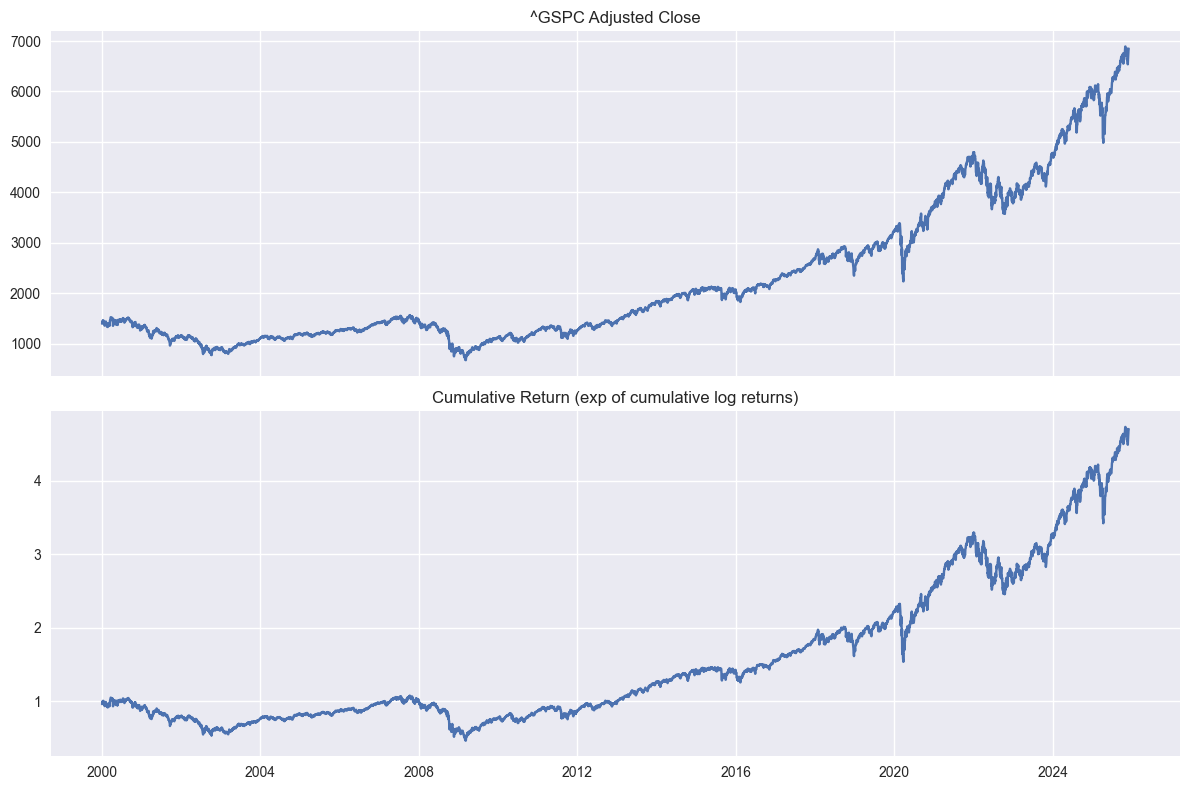

In [10]:
# Price & cumulative return
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data.index, data['AdjClose'])
axes[0].set_title(f"{TICKER} Adjusted Close")

axes[1].plot(data.index, data['CumReturn'])
axes[1].set_title("Cumulative Return (exp of cumulative log returns)")

plt.tight_layout()
plt.show()


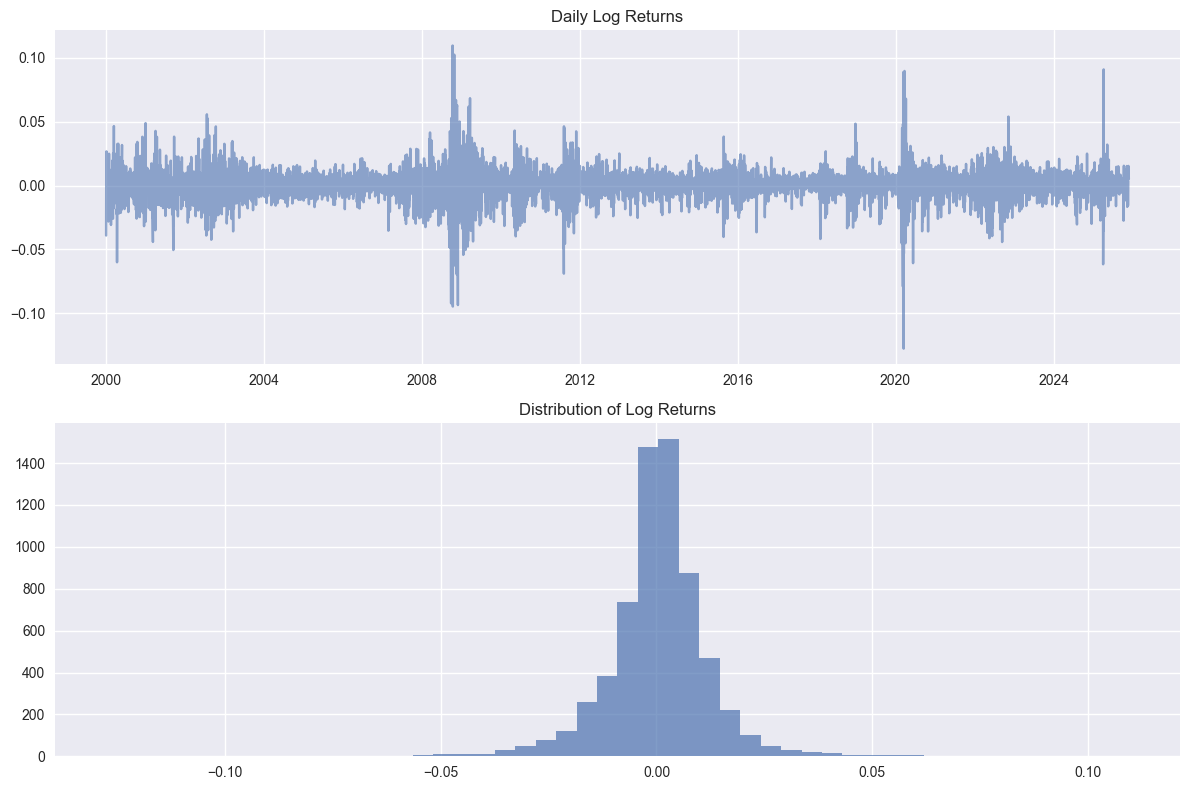

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(data.index, data['LogReturn'], alpha=0.6)
axes[0].set_title("Daily Log Returns")

axes[1].hist(data['LogReturn'], bins=50, alpha=0.7)
axes[1].set_title("Distribution of Log Returns")

plt.tight_layout()
plt.show()


In [12]:
processed = data[['AdjClose', 'SimpleReturn', 'LogReturn', 'RollingVol_21', 'CumReturn']].copy()
processed_path = os.path.join(DATA_PROCESSED_DIR, f"{TICKER.replace('^','')}_returns_processed.csv")
processed.to_csv(processed_path)
print("Saved processed returns to:", processed_path)


Saved processed returns to: c:\DAT494\bayesian_regime_switching\data\processed\GSPC_returns_processed.csv


In [13]:
assert processed.index.is_monotonic_increasing, "Index must be sorted by date"
assert processed['LogReturn'].isna().sum() == 0, "No NaNs in LogReturn allowed"
assert processed.shape[0] > 1000, "Not enough data points – check date range"
